```
from dPCA import dPCA
По обученной сети создается тензор
actR = размером(num_trial, hidden_size, S, T)
num_trial - число испытаний для каждого значения стимула
hidden_size - число нейронов сети
S - число стимулов (берем 10)
T - число временных отсчетов в одном испытании

from dPCA import dPCA

R = mean(actR,0)
R -= mean(R.reshape((hidden_size,-1)),1)[:,None,None]
dpca = dPCA.dPCA(labels='st',regularizer='auto')
dpca.protect = ['t']
Z = dpca.fit_transform(R, actR)

time = arange(T) 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for s in range(S) :
    ax1.plot(time, Z['t'][0,s]) 
for s in range(S) :
    ax2.plot(time, Z['s'][0,s])
for s in range(S) :
    ax3.plot(time, Z['st'][0,s])
    ```

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

from dPCA import dPCA
from cgtasknet.instruments.instrument_pca import PCA
from cgtasknet.net.states import LIFAdExRefracInitState
from cgtasknet.net.lifadexrefrac import SNNlifadexrefrac

from norse.torch.functional.lif_adex import LIFAdExParameters
from norse.torch.functional.lif_adex_refrac import LIFAdExRefracParameters

from cgtasknet.tasks.reduce import (
    RomoTaskParameters,
    RomoTask,
)

input_values = [0, 0.1, 0.2, 0.3, 0.4, 0.49, 0.51, 0.6, 0.7, 0.8, 0.9, 1]
feature_size = 4
output_size = 3
hidden_size = 450
batch_size = 1
tau_ada_inv_distrib = np.load(
    "..\\..\\..\\..\\models\\dm_and_romo\\lif_adex_refrac\\dm_and_romo_reduce_adex_refrac_450_95_percents_2000_epochs_alpha=100.npy"
)

neuron_parameters = LIFAdExRefracParameters(
    LIFAdExParameters(
        v_th=torch.as_tensor(0.65),
        tau_ada_inv=torch.from_numpy(tau_ada_inv_distrib),
        alpha=30,
        # method='heavi_erfc',
        method="super",
    ),
    rho_reset=torch.as_tensor(1),
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadexrefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
)
if True:
    model.load_state_dict(
        torch.load(
            "..\\..\\..\\..\\models\\dm_and_romo\\lif_adex_refrac\\dm_and_romo_reduce_adex_refrac_450_95_percents_2000_epochs_alpha=100"
        )
    )
init_state = LIFAdExRefracInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
second_state = init_state.random_state()
v_mean = None
a_mean = None
number_of_trials = 10
data_save = torch.zeros((0, 1, 4))
romoparams = RomoTaskParameters(
    delay=0.4,
    trial_time=0.15,
    # value = (first_value, second_value)
)
actR = np.zeros(
    (
        number_of_trials,
        hidden_size,
        len(input_values),
        int(
            (2 * romoparams.answer_time + romoparams.trial_time + romoparams.delay)
            / romoparams.dt
        ),
    )
)
actR_a = np.zeros_like(actR)
for trial in tqdm(range(number_of_trials)):
    v_save = torch.zeros((0, 1, hidden_size))
    a_save = torch.zeros((0, 1, hidden_size))
    for value in range(len(input_values)):
        romoparams = RomoTaskParameters(
            delay=0.4,
            trial_time=0.15,
            value=(0.5, input_values[value]),
        )
        Task = RomoTask(romoparams, mode="value")
        data, _ = Task.dataset(1)
        rule_matrix = np.zeros((data.shape[0], 1, 2))
        rule_matrix[:, :, 1] = 1
        data = np.concatenate((data, rule_matrix), axis=2)
        data = torch.from_numpy(data).type(torch.float)
        out, states = model(data, first_state)
        v = []
        s = []
        a = []
        # i = []
        for j in range(len(states)):
            v.append(states[j].lif_adex.v)
            s.append(states[j].lif_adex.z)
            a.append(states[j].lif_adex.a)

            # i.append(states[j].lif.i)
        a = torch.stack(a).detach()
        v = torch.stack(v).detach()
        actR[trial, :, value, :] = v[:, 0, :].T.numpy()
        actR_a[trial, :, value, :] = a[:, 0, :].T.numpy()
        v_save = torch.concat((v_save, v), axis=0)
        a_save = torch.concat((a_save, a), axis=0)
        if trial == 0:
            data_save = torch.concat((data_save, data), axis=0)

    # a_mean += a_save
# v_mean /= float(number_of_trials)
# a_mean /= float(number_of_trials)


# pca = PCA(3).decompose(v_mean.reshape(v_mean.shape[0], v_mean.shape[2]))
# pca_a = PCA(3).decompose(a_mean.reshape(a_mean.shape[0], a_mean.shape[2]))

s = torch.stack(s).detach()
s = s.cpu().numpy()

100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


# DPCA по мембранному потенциалу

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  2.892546549759998e-06
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


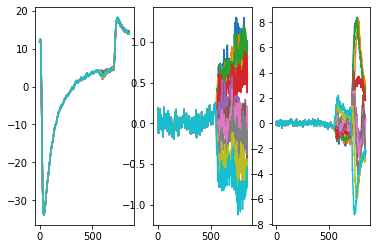

In [4]:
R = np.mean(actR, 0)
R -= np.mean(R.reshape((hidden_size, -1)), 1)[:, None, None]
dpca = dPCA.dPCA(labels="st", regularizer="auto")
dpca.protect = ["t"]
Z = dpca.fit_transform(R, actR)

time = np.arange(actR.shape[-1])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for s in range(actR.shape[0]):
    ax1.plot(time, Z["t"][0, s])
for s in range(actR.shape[0]):
    ax2.plot(time, Z["s"][0, s])
for s in range(actR.shape[0]):
    ax3.plot(time, Z["st"][0, s])

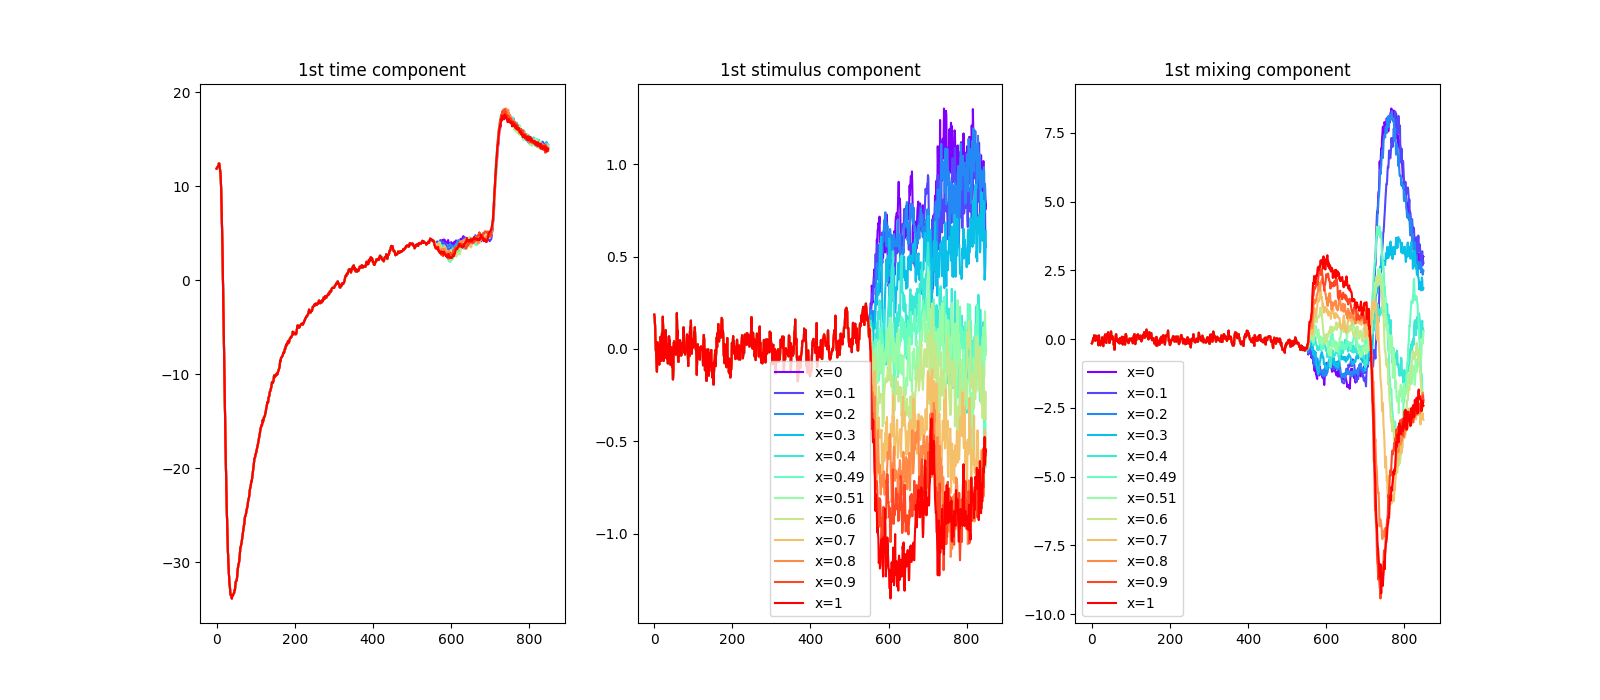

In [5]:
%matplotlib widget
from matplotlib.pyplot import cm

plt.figure(figsize=(16, 7))
plt.subplot(131)
S = actR.shape[2]
color = iter(cm.rainbow(np.linspace(0, 1, S)))
for s in range(S):
    c = next(color)
    plt.plot(time, Z["t"][0, s], c=c)

plt.title("1st time component")

plt.subplot(132)
color = iter(cm.rainbow(np.linspace(0, 1, S)))

for s in range(S):
    c = next(color)
    plt.plot(time, Z["s"][0, s], label=f"x={input_values[s]}", c=c)
plt.legend()
plt.title("1st stimulus component")

plt.subplot(133)
color = iter(cm.rainbow(np.linspace(0, 1, S)))

for s in range(S):
    c = next(color)

    plt.plot(time, Z["st"][0, s], label=f"x={input_values[s]}", c=c)
plt.legend()
plt.title("1st mixing component")
# plt.savefig('во время отклика dpca.pdf')
plt.show()

# DPCA по адаптивному потенциалу


You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  4.049565169663997e-06
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


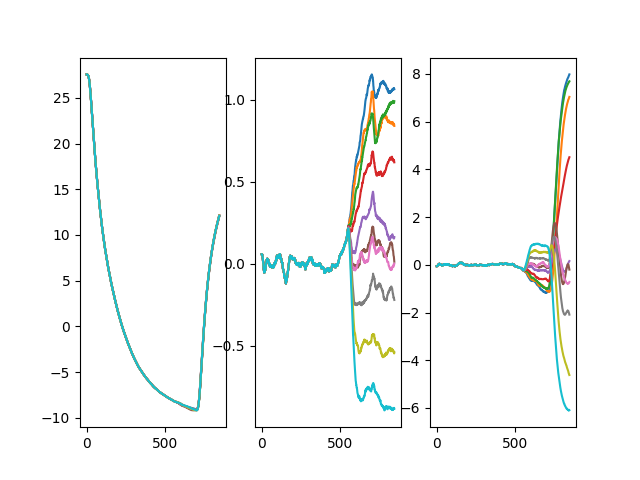

In [6]:
R = np.mean(actR_a, 0)
R -= np.mean(R.reshape((hidden_size, -1)), 1)[:, None, None]
dpca = dPCA.dPCA(labels="st", regularizer="auto")
dpca.protect = ["t"]
Z = dpca.fit_transform(R, actR_a)

time = np.arange(actR_a.shape[-1])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for s in range(actR_a.shape[0]):
    ax1.plot(time, Z["t"][0, s])
for s in range(actR_a.shape[0]):
    ax2.plot(time, Z["s"][0, s])
for s in range(actR_a.shape[0]):
    ax3.plot(time, Z["st"][0, s])

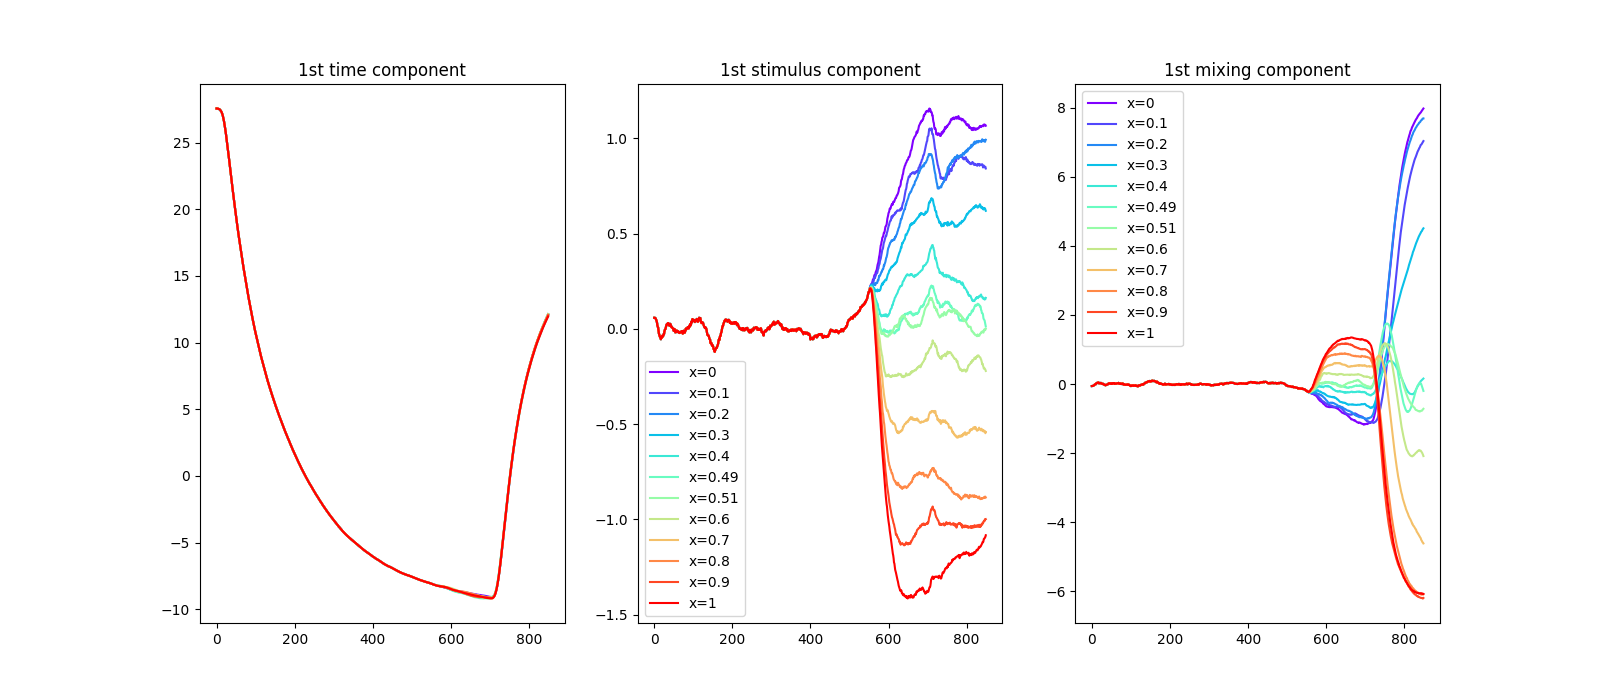

In [7]:
%matplotlib widget
from matplotlib.pyplot import cm

plt.figure(figsize=(16, 7))
plt.subplot(131)
S = actR.shape[2]
color = iter(cm.rainbow(np.linspace(0, 1, S)))
for s in range(S):
    c = next(color)
    plt.plot(time, Z["t"][0, s], c=c)

plt.title("1st time component")

plt.subplot(132)
color = iter(cm.rainbow(np.linspace(0, 1, S)))

for s in range(S):
    c = next(color)
    plt.plot(time, Z["s"][0, s], label=f"x={input_values[s]}", c=c)
plt.legend()
plt.title("1st stimulus component")

plt.subplot(133)
color = iter(cm.rainbow(np.linspace(0, 1, S)))

for s in range(S):
    c = next(color)

    plt.plot(time, Z["st"][0, s], label=f"x={input_values[s]}", c=c)
plt.legend()
plt.title("1st mixing component")
# plt.savefig('во время отклика dpca.pdf')
plt.show()

In [8]:
from cgtasknet.tasks import (
    MultyReduceTasks,
    RomoTaskRandomModParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
)
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

from dPCA import dPCA
from cgtasknet.instruments.instrument_pca import PCA
from cgtasknet.net.states import LIFAdExRefracInitState
from cgtasknet.net.lifadexrefrac import SNNlifadexrefrac

from norse.torch.functional.lif_adex import LIFAdExParameters
from norse.torch.functional.lif_adex_refrac import LIFAdExRefracParameters

from cgtasknet.tasks.reduce import (
    RomoTaskParameters,
    RomoTask,
)

feature_size = 4
output_size = 3
hidden_size = 450
batch_size = 1
tau_ada_inv_distrib = np.load(
    "..\\..\\..\\models\\dm_and_romo\\lif_adex_refrac\\dm_and_romo_reduce_adex_refrac_450_95_percents_2000_epochs_alpha=100.npy"
)

init_state = LIFAdExRefracInitState(batch_size, hidden_size)
neuron_parameters = LIFAdExRefracParameters(
    LIFAdExParameters(
        v_th=torch.as_tensor(0.65),
        tau_ada_inv=torch.from_numpy(tau_ada_inv_distrib),
        alpha=100,
        # method='heavi_erfc',
        method="super",
    ),
    rho_reset=torch.as_tensor(1),
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadexrefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
)
if True:
    model.load_state_dict(
        torch.load(
            "..\\..\\..\\models\\dm_and_romo\\lif_adex_refrac\\dm_and_romo_reduce_adex_refrac_450_95_percents_2000_epochs_alpha=100"
        )
    )
batch_size = 10
number_of_tasks = 1
romo_parameters = RomoTaskRandomModParameters(
    romo=RomoTaskParameters(
        delay=0.1,
        positive_shift_delay_time=0.5,
        trial_time=0.1,
        positive_shift_trial_time=0.2,
        answer_time=0.1,
    ),
    n_mods=1,
)
dm_parameters = DMTaskRandomModParameters(
    dm=DMTaskParameters(
        trial_time=0.1, positive_shift_trial_time=0.8, answer_time=0.15
    ),
    n_mods=1,
)

task_names = ["RomoTask1", "DMTask1"]
tasks = dict()
tasks[task_names[0]] = romo_parameters
tasks[task_names[1]] = dm_parameters
# task_parameters = RomoTaskParameters(delay=0.1, positive_shift_delay_time=.0, trial_time = 0.2, positive_shift_trial_time=.0)
Task = MultyReduceTasks(
    tasks=tasks,
    batch_size=batch_size,
    enable_fixation_delay=True,
    sequence_bathces=True,
    number_of_inputs=1,
)

ImportError: cannot import name 'MultyReduceTasks' from 'cgtasknet.tasks' (a:\src\multy_task\env\lib\site-packages\cgtasknet-0.0.1-py3.8.egg\cgtasknet\tasks\__init__.py)

In [ ]:
from cgtasknet.net.states import LIFAdExRefracInitState
from cgtasknet.instruments.instrument_accuracy_network import correct_answer
from tqdm import tqdm


result = 0
model = model.to(torch.device("cpu"))
for i in tqdm(range(1)):
    inputs, target_outputs = Task.dataset(3, delay_between=100)
    inputs += np.random.normal(0, 0.01, size=inputs.shape)
    inputs = torch.from_numpy(inputs).type(torch.float)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float)
    outputs = model(inputs)[0]
    # outputs = torch.reshape(outputs, shape=[outputs.shape[0], outputs.shape[1], outputs.shape[-1]])

    answers = correct_answer(
        outputs[:, :, 1:], target_outputs[:, :, 1:], target_outputs[:, :, 0]
    )
    result += torch.sum(answers).item()
round(result / batch_size / 4 * 100, 2)

In [ ]:
fig = plt.figure(figsize=(15, 10))

outputs = model(inputs)[0]
start = 0
for batch in range(start, 9 + start, 1):
    fig.add_subplot(520 + batch + 1 - start)
    plt.plot(outputs[:, batch, 1].detach().cpu())
    plt.plot(outputs[:, batch, 2].detach().cpu())
    plt.plot(target_outputs.detach().cpu()[:, batch, 1], label=f"t_out{2}")
    plt.plot(target_outputs.detach().cpu()[:, batch, 2], label=f"t_out{3}")
    plt.plot(inputs[:, batch, 1].detach().cpu())
    plt.legend()
    # plt.plot(inputs[:, 0, 0].detach().cpu())
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(15, 10))

outputs = model(inputs)[0]
start = 0
for batch in range(start, 9 + start, 1):
    fig.add_subplot(520 + batch + 1 - start)
    plt.plot(outputs[:, batch, 1].detach().cpu())
    plt.plot(outputs[:, batch, 2].detach().cpu())
    plt.plot(target_outputs.detach().cpu()[:, batch, 1], label=f"t_out{2}")
    plt.plot(target_outputs.detach().cpu()[:, batch, 2], label=f"t_out{3}")
    plt.plot(inputs[:, batch, 1].detach().cpu())
    plt.legend()
    # plt.plot(inputs[:, 0, 0].detach().cpu())
plt.tight_layout()
plt.show()
plt.close()